In [1]:
# import statements

import pandas as pd
import numpy as np
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import Series

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from random import shuffle

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE


/Users/nickeylawrence/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read the Gear2 data
Gear2Files = ['./Gear2/segment2.csv', './Gear2/segment3.csv','./Gear2/segment4.csv',
              './Gear2/segment5.csv','./Gear2/segment6.csv']

X_Gear2=[0] * len(Gear2Files)
Y_Gear2=[0] * len(Gear2Files)
for index,file in enumerate(Gear2Files):
    X_Gear2[index] = pd.read_csv(file);
    Y_Gear2[index] = pd.DataFrame(data= np.full((X_Gear2[index].shape[0],1), 2));
    X_Gear2[index] = X_Gear2[index].assign(Gear=Y_Gear2[index].values);

# Read the Gear3 data
Gear3Files = ['./Gear3/segment1.csv', './Gear3/segment2.csv','./Gear3/segment3.csv',
              './Gear3/segment4.csv','./Gear3/segment5.csv', './Gear3/segment6.csv']

X_Gear3=[0] * len(Gear3Files)
Y_Gear3=[0] * len(Gear3Files)
for index,file in enumerate(Gear3Files):
    X_Gear3[index] = pd.read_csv(file);
    Y_Gear3[index] = pd.DataFrame(data= np.full((X_Gear3[index].shape[0],1), 3));
    X_Gear3[index] = X_Gear3[index].assign(Gear=Y_Gear3[index].values);

# Read the Gear4 data
Gear4Files = ['./Gear4/segment2.csv','./Gear4/segment3.csv','./Gear4/segment4.csv',
              './Gear4/segment5.csv', './Gear4/segment6a.csv','./Gear4/segment6b.csv']

X_Gear4=[0] * len(Gear4Files)
Y_Gear4=[0] * len(Gear4Files)
for index,file in enumerate(Gear4Files):
    X_Gear4[index] = pd.read_csv(file);
    Y_Gear4[index] = pd.DataFrame(data= np.full((X_Gear4[index].shape[0],1), 4));
    X_Gear4[index] = X_Gear4[index].assign(Gear=Y_Gear4[index].values);

# Read the Gear 5 data
Gear5Files = ['./Double/segment1.csv','./Double/segment2.csv','./Double/segment3.csv',
              './Double/segment4.csv', './Double/segment5.csv','./Double/segment7.csv']

X_Gear5=[0] * len(Gear5Files)
Y_Gear5=[0] * len(Gear5Files)
for index,file in enumerate(Gear5Files):
    X_Gear5[index] = pd.read_csv(file);
    Y_Gear5[index] = pd.DataFrame(data= np.full((X_Gear5[index].shape[0],1), 5));
    X_Gear5[index] = X_Gear5[index].assign(Gear=Y_Gear5[index].values);

In [3]:
limit = 750

XGear=[]
for index, dataG2 in enumerate(X_Gear2):
    gearRange = math.ceil(len(dataG2)/limit)
    XGear += [dataG2[t*limit:t*limit + limit] for t in range(gearRange)]

for index, dataG3 in enumerate(X_Gear3):
    gearRange = math.ceil(len(dataG3)/limit)
    XGear += [dataG3[t*limit:t*limit + limit] for t in range(gearRange)]

for index, dataG4 in enumerate(X_Gear4):
    gearRange = math.ceil(len(dataG4)/limit)
    XGear += [dataG4[t*limit:t*limit + limit] for t in range(gearRange)]
    
for index, dataG5 in enumerate(X_Gear5):
    gearRange = math.ceil(len(dataG5)/limit)
    XGear += [dataG5[t*limit:t*limit + limit] for t in range(gearRange)]

In [4]:
X = XGear[:] # Copy words
shuffle(X) 

In [5]:
X = pd.concat(X);

In [6]:
data = pd.DataFrame(X);

data.reset_index(inplace = True, drop = True)
for i in range(len(data)):
    data.loc[i,'t'] = i*0.02

In [7]:
# Normalisation
# Feature normalization
# Normalize Time Series Data
# Source : https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

# Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
# useful when your time series data has input values with differing scales.
features = list(data.columns);
scaledFeatures = [item for item in features if item not in ['t','Gear']]

for i in range(len(scaledFeatures)):
    feature = scaledFeatures[i];
    print('Scaling feature : ', scaledFeatures[i])
    values = X[feature].values.reshape(-1,1);
    values = values.astype('float32');
    scaler = MinMaxScaler(feature_range = (0,1));
    scaled_f = scaler.fit_transform(values);
    X[feature] = scaled_f;

Scaling feature :  fL
Scaling feature :  thL
Scaling feature :  w1L
Scaling feature :  w2L
Scaling feature :  w3L
Scaling feature :  a1L
Scaling feature :  a2L
Scaling feature :  a3L
Scaling feature :  fR
Scaling feature :  thR
Scaling feature :  w1R
Scaling feature :  w2R
Scaling feature :  w3R
Scaling feature :  a1R
Scaling feature :  a2R
Scaling feature :  a3R
Scaling feature :  x
Scaling feature :  y
Scaling feature :  v
Scaling feature :  vdir


[0.01213812 0.00549306 0.00348852 0.00157947 0.00404406 0.00335761
 0.00358076 0.00345828 0.02720312 0.01541619 0.0017189  0.00159628
 0.00264182 0.00117846 0.00462887 0.00320357 0.37801726 0.14620593
 0.14892101 0.23212873]


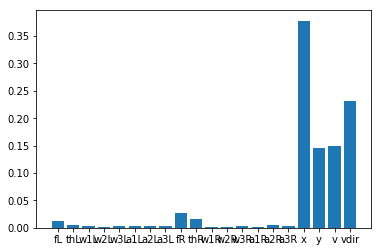

In [8]:
# Feature importance is one method to help sort out what might be more useful in when modeling.

# load data
array = data.values

# split into input and output
X = array[:,1:-1]
y = array[:,-1]

# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)

# show importance scores
print(model.feature_importances_)

# plot importance scores
names = data.columns.values[1:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

In [9]:
# Create one-hot Y vectors
features.remove('Gear')
X = data[features]
Y = data['Gear']
# Create one-hot Y vectors
Y_onehot = pd.get_dummies(Y).values;

In [10]:
print(Y_onehot)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]


In [11]:
X = np.array(X)
Y = np.array(Y_onehot)

In [12]:
timesteps = 1
XNew = X.reshape(X.shape[0],timesteps,21)
YNew = Y.reshape(Y.shape[0],timesteps,4)

trainX, testX, trainY, testY = train_test_split(XNew, YNew, test_size=0.2);

trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2);

In [13]:
# design and fit our LSTM network

model = Sequential();
model.add(LSTM(64, return_sequences = True, input_shape = (timesteps, 20)));
model.add(Dense(4, activation = 'softmax'));
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history = model.fit(trainX[:,:,1:], trainY, epochs=250, batch_size=100, validation_data=(valX[:,:,1:],valY))


Train on 16608 samples, validate on 4152 samples
Epoch 1/250
16608/16608 [==============================] - 16s 943us/step - loss: 1.2110 - categorical_accuracy: 0.4533 - val_loss: 0.9225 - val_categorical_accuracy: 0.6344
Epoch 2/250
16608/16608 [==============================] - 10s 608us/step - loss: 0.7880 - categorical_accuracy: 0.6652 - val_loss: 0.7198 - val_categorical_accuracy: 0.6852
Epoch 3/250
16608/16608 [==============================] - 9s 530us/step - loss: 0.6887 - categorical_accuracy: 0.6876 - val_loss: 0.6729 - val_categorical_accuracy: 0.6912
Epoch 4/250
16608/16608 [==============================] - 8s 489us/step - loss: 0.6591 - categorical_accuracy: 0.6955 - val_loss: 0.6512 - val_categorical_accuracy: 0.6956
Epoch 5/250
16608/16608 [==============================] - 9s 560us/step - loss: 0.6420 - categorical_accuracy: 0.6992 - val_loss: 0.6441 - val_categorical_accuracy: 0.7158
Epoch 6/250
16608/16608 [==============================] - 8s 476us/step - loss: 0.6

Epoch 48/250
16608/16608 [==============================] - 7s 440us/step - loss: 0.4613 - categorical_accuracy: 0.7990 - val_loss: 0.4696 - val_categorical_accuracy: 0.8039
Epoch 49/250
16608/16608 [==============================] - 10s 579us/step - loss: 0.4580 - categorical_accuracy: 0.8023 - val_loss: 0.4613 - val_categorical_accuracy: 0.7991
Epoch 50/250
16608/16608 [==============================] - 11s 637us/step - loss: 0.4565 - categorical_accuracy: 0.8025 - val_loss: 0.4755 - val_categorical_accuracy: 0.8061
Epoch 51/250
16608/16608 [==============================] - 10s 605us/step - loss: 0.4555 - categorical_accuracy: 0.8027 - val_loss: 0.4657 - val_categorical_accuracy: 0.7712
Epoch 52/250
16608/16608 [==============================] - 11s 679us/step - loss: 0.4521 - categorical_accuracy: 0.8066 - val_loss: 0.4541 - val_categorical_accuracy: 0.8073
Epoch 53/250
16608/16608 [==============================] - 10s 621us/step - loss: 0.4486 - categorical_accuracy: 0.8056 - val

16608/16608 [==============================] - 8s 485us/step - loss: 0.3530 - categorical_accuracy: 0.8489 - val_loss: 0.3593 - val_categorical_accuracy: 0.8514
Epoch 95/250
16608/16608 [==============================] - 7s 435us/step - loss: 0.3524 - categorical_accuracy: 0.8497 - val_loss: 0.3640 - val_categorical_accuracy: 0.8463
Epoch 96/250
16608/16608 [==============================] - 10s 584us/step - loss: 0.3525 - categorical_accuracy: 0.8501 - val_loss: 0.3557 - val_categorical_accuracy: 0.8497
Epoch 97/250
16608/16608 [==============================] - 10s 625us/step - loss: 0.3503 - categorical_accuracy: 0.8515 - val_loss: 0.3537 - val_categorical_accuracy: 0.8512
Epoch 98/250
16608/16608 [==============================] - 6s 350us/step - loss: 0.3482 - categorical_accuracy: 0.8512 - val_loss: 0.3501 - val_categorical_accuracy: 0.8509
Epoch 99/250
16608/16608 [==============================] - 6s 369us/step - loss: 0.3469 - categorical_accuracy: 0.8509 - val_loss: 0.3592 - 

16608/16608 [==============================] - 5s 292us/step - loss: 0.2802 - categorical_accuracy: 0.8832 - val_loss: 0.2994 - val_categorical_accuracy: 0.8767
Epoch 141/250
16608/16608 [==============================] - 5s 275us/step - loss: 0.2793 - categorical_accuracy: 0.8832 - val_loss: 0.3192 - val_categorical_accuracy: 0.8630
Epoch 142/250
16608/16608 [==============================] - 4s 241us/step - loss: 0.2787 - categorical_accuracy: 0.8841 - val_loss: 0.2847 - val_categorical_accuracy: 0.8801
Epoch 143/250
16608/16608 [==============================] - 4s 227us/step - loss: 0.2761 - categorical_accuracy: 0.8866 - val_loss: 0.2845 - val_categorical_accuracy: 0.8858
Epoch 144/250
16608/16608 [==============================] - 4s 233us/step - loss: 0.2751 - categorical_accuracy: 0.8859 - val_loss: 0.2850 - val_categorical_accuracy: 0.8839
Epoch 145/250
16608/16608 [==============================] - 5s 278us/step - loss: 0.2732 - categorical_accuracy: 0.8868 - val_loss: 0.2926

16608/16608 [==============================] - 5s 300us/step - loss: 0.2295 - categorical_accuracy: 0.9078 - val_loss: 0.2454 - val_categorical_accuracy: 0.9015ca
Epoch 187/250
16608/16608 [==============================] - 4s 265us/step - loss: 0.2269 - categorical_accuracy: 0.9114 - val_loss: 0.2336 - val_categorical_accuracy: 0.9085
Epoch 188/250
16608/16608 [==============================] - 5s 281us/step - loss: 0.2263 - categorical_accuracy: 0.9088 - val_loss: 0.2343 - val_categorical_accuracy: 0.9068
Epoch 189/250
16608/16608 [==============================] - 4s 269us/step - loss: 0.2253 - categorical_accuracy: 0.9096 - val_loss: 0.2381 - val_categorical_accuracy: 0.9104
Epoch 190/250
16608/16608 [==============================] - 5s 294us/step - loss: 0.2228 - categorical_accuracy: 0.9120 - val_loss: 0.2427 - val_categorical_accuracy: 0.9008
Epoch 191/250
16608/16608 [==============================] - 5s 327us/step - loss: 0.2232 - categorical_accuracy: 0.9120 - val_loss: 0.23

Epoch 233/250
16608/16608 [==============================] - 4s 237us/step - loss: 0.1894 - categorical_accuracy: 0.9260 - val_loss: 0.1976 - val_categorical_accuracy: 0.9234
Epoch 234/250
16608/16608 [==============================] - 5s 279us/step - loss: 0.1879 - categorical_accuracy: 0.9271 - val_loss: 0.2142 - val_categorical_accuracy: 0.9171
Epoch 235/250
16608/16608 [==============================] - 5s 305us/step - loss: 0.1861 - categorical_accuracy: 0.9280 - val_loss: 0.2013 - val_categorical_accuracy: 0.9196
Epoch 236/250
16608/16608 [==============================] - 7s 407us/step - loss: 0.1860 - categorical_accuracy: 0.9286 - val_loss: 0.2195 - val_categorical_accuracy: 0.9114
Epoch 237/250
16608/16608 [==============================] - 5s 277us/step - loss: 0.1847 - categorical_accuracy: 0.9288 - val_loss: 0.2031 - val_categorical_accuracy: 0.9241
Epoch 238/250
16608/16608 [==============================] - 4s 255us/step - loss: 0.1859 - categorical_accuracy: 0.9253 - va

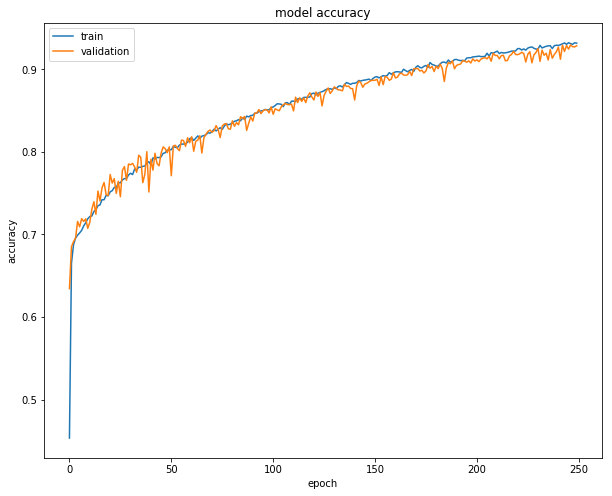

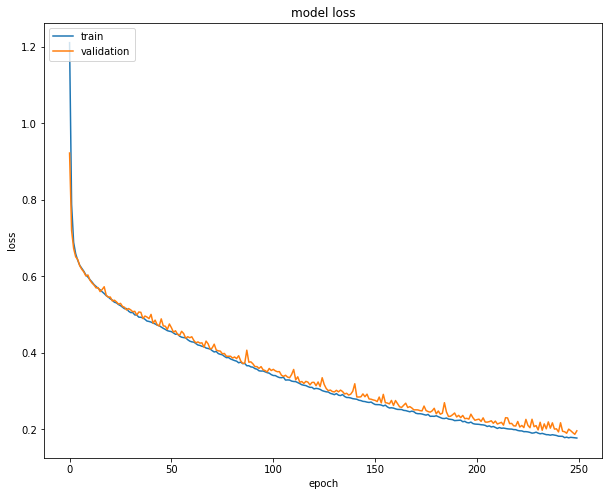

In [16]:
# summarize history for accuracy
plt.figure(0,figsize=(10, 8))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(0,figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
# Evaluate
predictions = model.predict_classes(testX[:,:,1:])

In [18]:
scores = model.evaluate(testX[:,:,1:], testY, verbose=2)
print(scores)

[0.18953982836823471, 0.9302504816955685]


In [19]:
timeTest = np.array(testX[:,:,0])
forceLeftTest = np.array(testX[:,:,1])
forceRightTest = np.array(testX[:,:,9])
predTest = np.array(predictions+2)
realTest = np.array(np.argmax(testY, axis=2)+2)
result = np.concatenate((timeTest,forceLeftTest, forceRightTest, predTest, realTest), axis=1)

In [20]:
ind=np.argsort(result[:,0])
result2 = result[ind]

#### Prediction of dfifferent gears based on force left and force right on the test data set

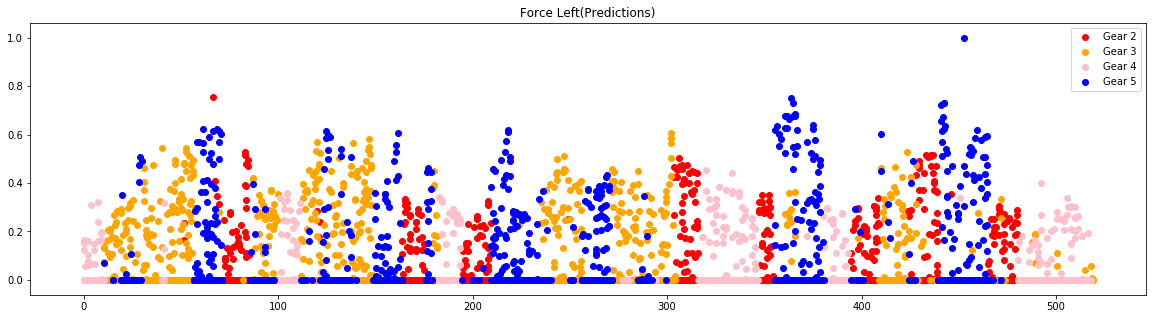

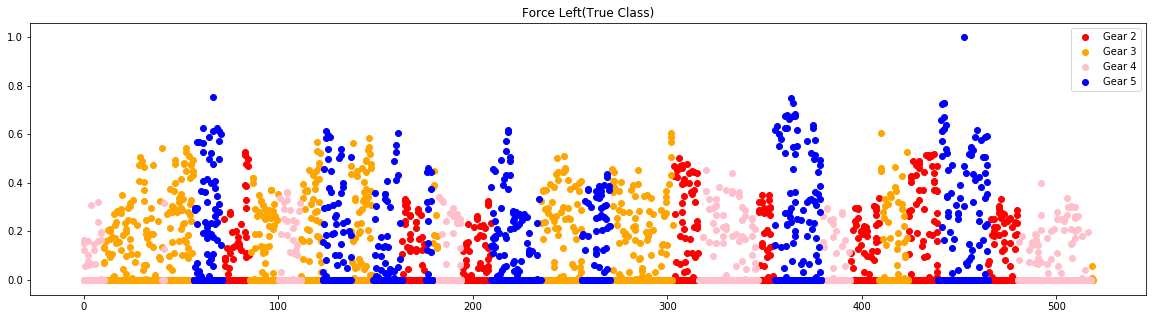

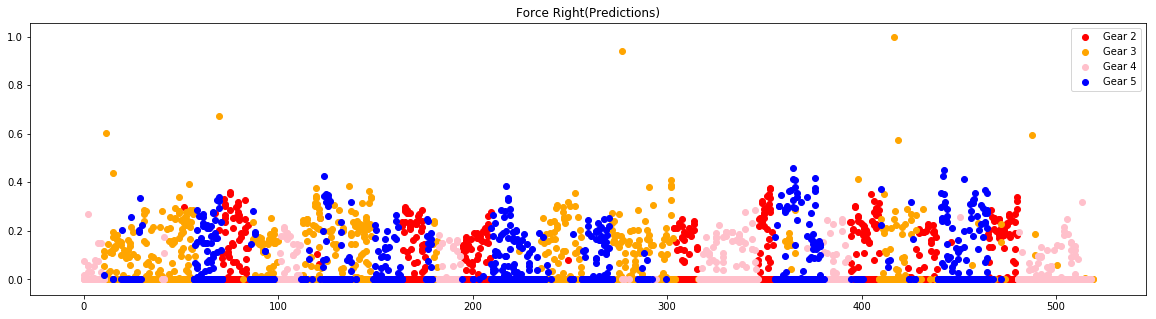

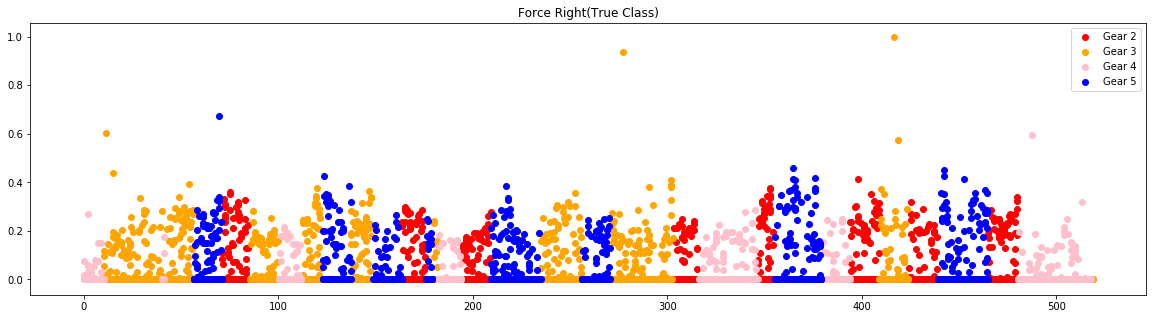

In [24]:
plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Left(Predictions)')
for i in range(2,6):
    classResult = result[result[:,3]==i]
    plt.scatter(classResult[:,0],classResult[:,1],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Left(True Class)')
for i in range(2,6):
    classRealResult = result[result[:,4]==i]
    plt.scatter(classRealResult[:,0],classRealResult[:,1],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
plt.title('Force Right(Predictions)')
for i in range(2,6):
    classResult = result[result[:,3]==i]
    plt.scatter(classResult[:,0],classResult[:,2],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Right(True Class)')
for i in range(2,6):
    classRealResult = result[result[:,4]==i]
    plt.scatter(classRealResult[:,0],classRealResult[:,2],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

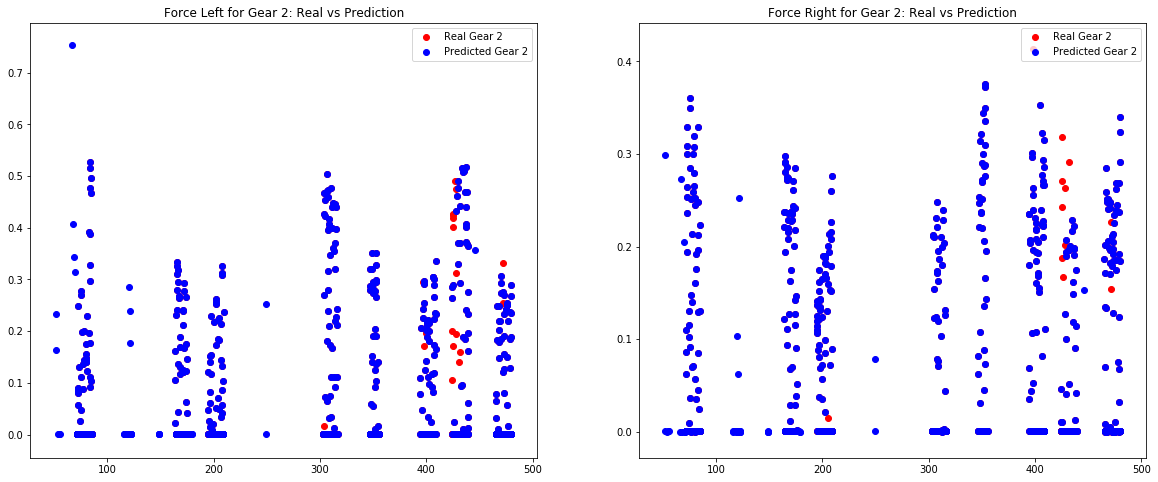

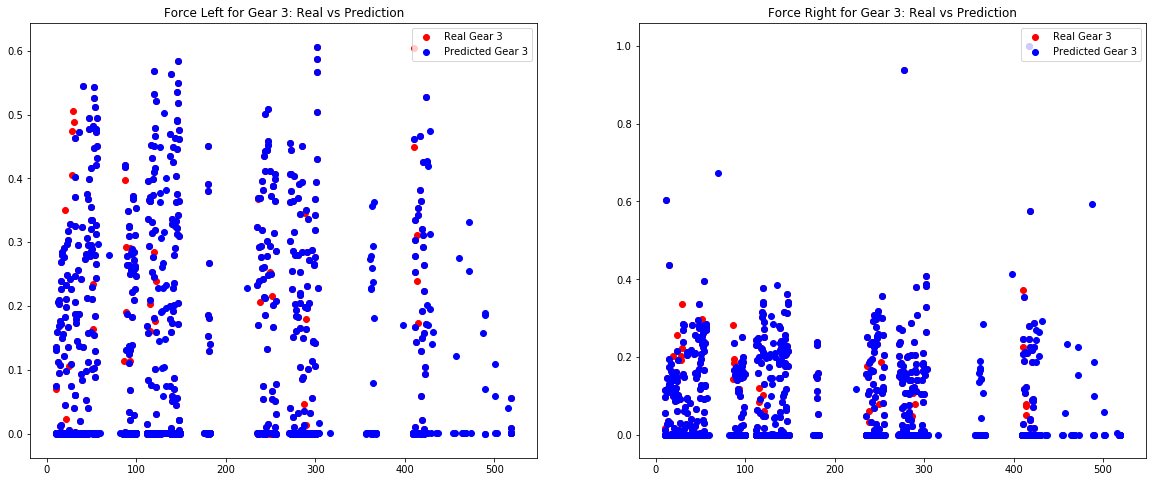

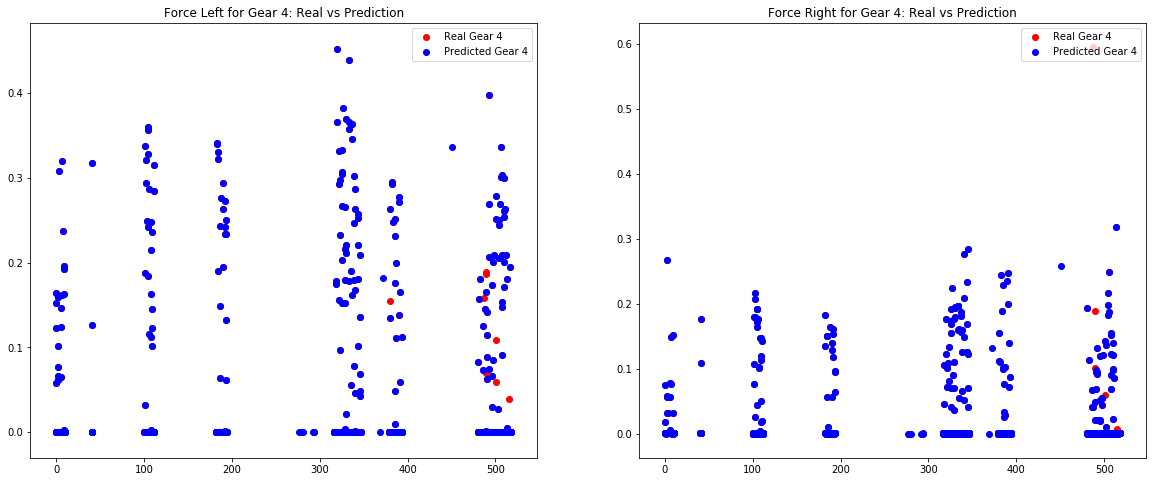

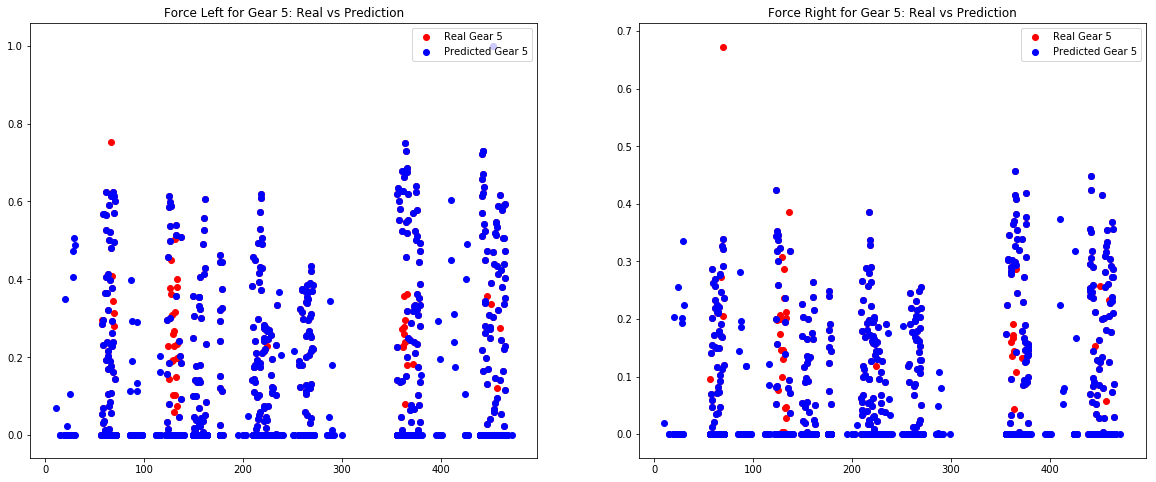

In [22]:
for i in range(2,6):
    classPredResult = result[result[:,3]==i]
    classRealResult = result[result[:,4]==i]
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))
    
    ax1.set_title('Force Left for Gear '+str(i) +': Real vs Prediction') 
    ax1.scatter(classRealResult[:,0],classRealResult[:,1],c ='red',label='Real Gear ' + str(i))
    ax1.scatter(classPredResult[:,0],classPredResult[:,1],c ='blue',label='Predicted Gear ' + str(i))
    ax1.legend(loc="upper right")
    
    ax2.set_title('Force Right for Gear '+str(i) +': Real vs Prediction') 
    ax2.scatter(classRealResult[:,0],classRealResult[:,2],c ='red',label='Real Gear ' + str(i))
    ax2.scatter(classPredResult[:,0],classPredResult[:,2],c ='blue',label='Predicted Gear ' + str(i))
    ax2.legend(loc="upper right")
plt.show()    

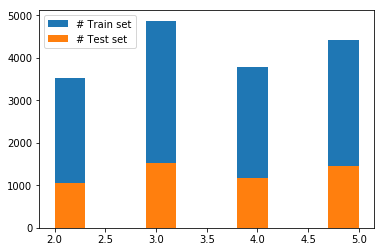

In [23]:
# Count of data for each gear in training set
i = (np.argmax(trainY, axis = 2)) + 2

# Count of data for each gear in test set
j = (np.argmax(testY, axis = 2)) + 2

plt.hist(i, label = '# Train set')
plt.hist(j, label = '# Test set')
plt.legend()
plt.show()